In [4]:
'''
benchmark test for algorithms' efficiency
'''
# fixed random state
# 95% accuracy
# test accuracy increase
# test training time
# no learning rate tweaking

"\nbenchmark test for algorithms' efficiency\n"

In [5]:
# import
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
from tensorflow.contrib.layers import fully_connected, batch_norm
from tensorflow.contrib.layers import dropout
from datetime import datetime
from time import time

In [6]:
# global variables that doesn't need to be updated every run
np_seed = 4
tf_seed = 11

In [7]:
# variables that need to be changed
method = "batchnorm"

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


(60000, 784) (10000, 784) (60000,) (10000,)
-0.470742984694


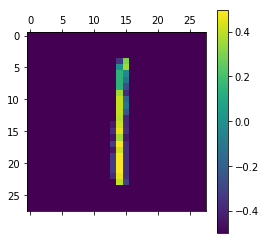

In [8]:
# prepare data
np.random.seed(np_seed)
mnist = fetch_mldata("MNIST original")
train_size = 60000
X_train, X_test, y_train, y_test = train_test_split(mnist.data/256-0.5, mnist.target.astype(int), train_size=train_size,shuffle=True)
m,n = X_train.shape
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# make sure things go well
print(np.mean(X_train[40]))
plt.matshow(X_train[40].reshape([28,28]))
plt.colorbar()
plt.show()

In [9]:
def fetch_batch(X,y,batch_size):
    random_indice = np.random.permutation(X.shape[0])[:batch_size]
    return [X[random_indice], y[random_indice]]
def get_lr(lr_start,epoch):
    return lr_start/(2**(epoch/300.))

In [12]:
# construction phase
now = datetime.utcnow().strftime("%y%m%d-%H%M")
root_logdir = "logs"
logdir_train = "{}/{}_{}_train".format(root_logdir, method, now)
logdir_test = "{}/{}_{}_test".format(root_logdir,method,now)
root_savedir = "checkpoints"
savedir = "{}/{}_{}".format(root_savedir, method, now)

tf.reset_default_graph()
tf.set_random_seed(tf_seed) # set random seed
n_neurons = 50
lr_start = 0.1

X = tf.placeholder(tf.float32, shape=[None, 784])
y = tf.placeholder(tf.int64, shape=[None])
is_training = tf.placeholder(tf.bool, shape=(), name="is_training")

bn_params = {
'is_training': is_training,
'decay': 0.99,
'updates_collections': None
}

with tf.variable_scope("forward"):
    dense_1 = fully_connected(X, 64, scope="dense_1",normalizer_fn=batch_norm,normalizer_params=bn_params)
    dense_2 = fully_connected(dense_1, 32, scope="dense_2",normalizer_fn=batch_norm,normalizer_params=bn_params)
    output = fully_connected(dense_2, 10, activation_fn=None, scope="output")
    
with tf.variable_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=output, labels=y,name="xentropy")
    loss = tf.reduce_mean(xentropy,name="loss")
    
with tf.variable_scope("annealing"):
    lr = tf.placeholder(tf.float32, shape=(), name="learning_rate")
    
with tf.variable_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(lr)
    training_op = optimizer.minimize(loss)

with tf.variable_scope("eval"):
    pred = tf.argmax(output,axis=1,name="prediction")
    accuracy = tf.reduce_mean(tf.cast(tf.equal(pred,y),tf.float64))
with tf.variable_scope("save"):
    saver = tf.train.Saver()
    loss_summary = tf.summary.scalar("loss", loss)
    accuracy_summary = tf.summary.scalar("accuracy", accuracy)
    summary = tf.summary.merge_all()
    writer_test = tf.summary.FileWriter(logdir_test,tf.get_default_graph())
    writer_train = tf.summary.FileWriter(logdir_train,tf.get_default_graph())
# execution phase
with tf.Session() as sess:
    np.random.seed(np_seed) # set random seed
    start_running = time()
    sess.run(tf.global_variables_initializer())
    n_epochs = 300
    batch_size = 1000
    n_batches = int(np.ceil(m/batch_size))
    
    for epoch in range(n_epochs):
        lr_ = get_lr(lr_start,epoch)
        for batch in range(n_batches):
            X_batch, y_batch = fetch_batch(X_train, y_train, batch_size)
            sess.run(training_op, feed_dict={X:X_batch,y:y_batch,lr:lr_,is_training:True})
        if epoch%10==0:
            start_time = time()
            summary_test, loss_test,  accuracy_test  = sess.run([summary,loss,accuracy],feed_dict={X:X_test,y:y_test,is_training:False})
            writer_test.add_summary(summary_test,epoch)
            summary_train,loss_train,  accuracy_train  = sess.run([summary,loss,accuracy],feed_dict={X:X_train,y:y_train,is_training:False})
            writer_train.add_summary(summary_train,epoch)
            
            print("Epoch:",epoch)
            print("test loss : %.4f" % loss_test , "test accuracy : %.4f" % accuracy_test)
            print("train loss: %.4f" % loss_train, "train accuracy: %.4f" % accuracy_train)
            print("elapsed time: %.0f" % (time()-start_running), "lr: %.1e" % lr_)
            print("Time to log:",time()-start_time)
        if epoch%50==0:
            saver.save(sess,savedir+"/model.ckpt")
    saver.save(sess,savedir+"/model_final.ckpt")
    train_accuracy = sess.run(accuracy, feed_dict={X:X_train, y:y_train,is_training:False})
    test_accuracy = sess.run(accuracy, feed_dict={X:X_test, y:y_test,is_training:False})
    print("Test accuracy :", test_accuracy)
    print("Train accuracy:", train_accuracy)
    sess.run(writer_test.close())
    sess.run(writer_train.close())

Epoch: 0
test loss : 0.9879 test accuracy : 0.7967
train loss: 0.9721 train accuracy: 0.8020
elapsed time: 7 lr: 1.0e-01
Time to log: 1.6504669189453125
Epoch: 10
test loss : 0.1595 test accuracy : 0.9555
train loss: 0.1295 train accuracy: 0.9661
elapsed time: 51 lr: 9.8e-02
Time to log: 1.330540657043457
Epoch: 20
test loss : 0.1207 test accuracy : 0.9661
train loss: 0.0783 train accuracy: 0.9804
elapsed time: 93 lr: 9.5e-02
Time to log: 1.470914363861084
Epoch: 30
test loss : 0.1090 test accuracy : 0.9683
train loss: 0.0553 train accuracy: 0.9871
elapsed time: 133 lr: 9.3e-02
Time to log: 1.1721196174621582
Epoch: 40
test loss : 0.1044 test accuracy : 0.9698
train loss: 0.0409 train accuracy: 0.9913
elapsed time: 172 lr: 9.1e-02
Time to log: 1.158583641052246
Epoch: 50
test loss : 0.1021 test accuracy : 0.9698
train loss: 0.0319 train accuracy: 0.9943
elapsed time: 210 lr: 8.9e-02
Time to log: 1.115565538406372
Epoch: 60
test loss : 0.1021 test accuracy : 0.9697
train loss: 0.0247 tr

TypeError: Fetch argument None has invalid type <class 'NoneType'>